In [1]:
# Multi-UAV Real-Time Path Planning System
# Jupyter Notebook: main.ipynb
# Setup and Imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

sys.path.append('./env')
from uav_env import RealTimeMultiUAVEnv

# Environment setup
env = RealTimeMultiUAVEnv(grid_size=10, num_uavs=3, real_coords=True)

# Pre-training data generation
obs = env.reset()
pre_training_data = []

for step in range(50):  # Generate random UAV behavior
    actions = env.action_space.sample()
    obs, reward, done, info = env.step(actions)
    
    for i in range(env.num_uavs):
        real_coords = env.get_real_coordinates(env.uav_positions[i])
        row = {
            'ID': f'UAV{i}',
            'source_time': step,
            'lat': real_coords[0],
            'lon': real_coords[1],
            'source_spotted': env.uav_spotted[i],
            'track': env.uav_tracks[i],
            'takeoff_landing_time': step,  # Replaced uav_flight_time with step
            'battery': env.uav_batteries[i],
            'AoI': np.sum(env.visited),  # Using sum of visited grid
            'FLA': env.step_count
        }
        pre_training_data.append(row)

# Save to CSV
pre_training_df = pd.DataFrame(pre_training_data)
os.makedirs("data", exist_ok=True)
pre_training_df.to_csv("data/external_obs_pretrain.csv", index=False)

# Display
print("\n✅ Pre-training data saved to 'data/external_obs_pretrain.csv'")
display(pre_training_df.head())



✅ Pre-training data saved to 'data/external_obs_pretrain.csv'


,ID,source_time,lat,lon,source_spotted,track,takeoff_landing_time,battery,AoI,FLA
0,UAV0,0,52.824992,-4.126736,0,180,0,98.0,3.0,1
1,UAV1,0,52.818992,-4.126736,0,180,0,98.0,3.0,1
2,UAV2,0,52.820992,-4.131736,0,270,0,98.0,3.0,1
3,UAV0,1,52.824992,-4.126736,0,180,1,97.5,5.0,2
4,UAV1,1,52.818992,-4.125736,0,90,1,96.0,5.0,2



🚀 Initializing UAV training environment...
📦 Generating pre-training data...


,ID,source_time,lat,lon,source_spotted,track,takeoff_landing_time,battery,AoI,FLA
0,UAV0,0,52.824992,-4.131736,0,147,0,100,0.0,0
1,UAV1,0,52.817992,-4.122736,0,-59,0,100,0.0,0
2,UAV2,0,52.816992,-4.128736,0,-11,0,100,0.0,0


🧠 Creating PPO model...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
🎯 Starting training for 50000 timesteps...
Logging to logs/MultiUAV_PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 496      |
| time/              |          |
|    fps             | 346      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 492         |
| time/                   |             |
|    fps                  | 279         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007329678 |
|    c

,ID,source_time,lat,lon,source_spotted,track,takeoff_landing_time,battery,AoI,FLA
0,UAV0,0,52.824992,-4.125736,0,180,0,0,29.0,200
1,UAV1,0,52.816992,-4.122736,1,90,0,0,29.0,200
2,UAV2,0,52.815992,-4.128736,0,0,0,0,29.0,200


📊 Saving training metrics...
Metrics saved to data/training_metrics.csv
Summary saved to data/training_metrics_summary.json
🏁 Training completed successfully!

🎉 All tasks complete!


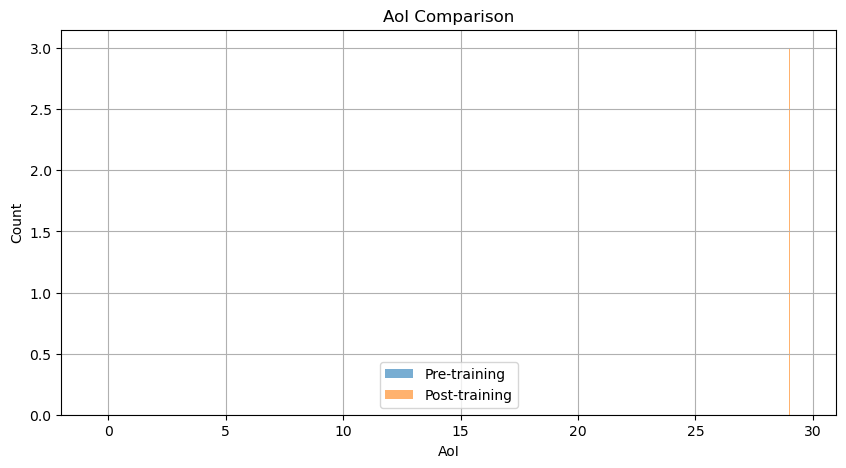

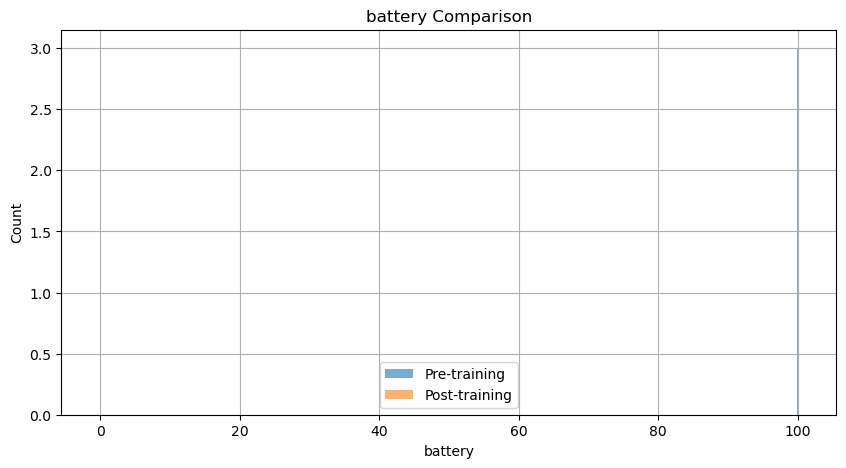

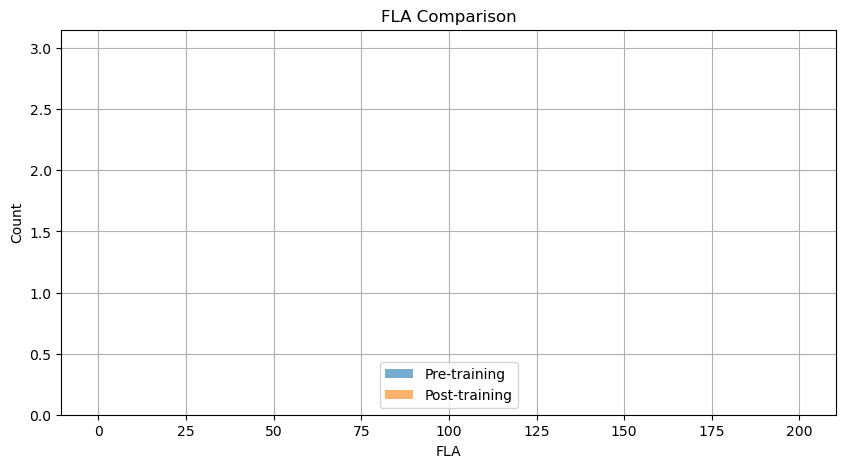

In [2]:

# ===============================
# 🚀 UAV PPO Training Notebook
# ===============================

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

sys.path.append('./env')
sys.path.append('./utils')

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from env.uav_env import RealTimeMultiUAVEnv
from utils.metrics import MetricsTracker

# =============================
# Callback Class
# =============================

class TrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingCallback, self).__init__(verbose)
        self.episode_count = 0
        self.metrics = MetricsTracker()

    def _on_step(self) -> bool:
        if self.locals.get('dones', [False])[0]:
            self.episode_count += 1
            if self.episode_count % 10 == 0:
                env = self.training_env.get_attr('unwrapped')[0]
                coverage = np.sum(env.visited) / (env.grid_size ** 2)
                self.metrics.log_episode(
                    episode=self.episode_count,
                    coverage=coverage,
                    steps=env.step_count,
                    active_uavs=sum(1 for b in env.uav_batteries if b > 0),
                    total_spots=sum(env.uav_spotted)
                )
                if self.verbose:
                    print(f"Episode {self.episode_count}: Coverage={coverage:.2f}, Steps={env.step_count}")
        return True

# =============================
# Train Function
# =============================

def train_model(total_timesteps=50000, model_name="ppo_MultiUAVEnv"):
    print("\n🚀 Initializing UAV training environment...")
    env = RealTimeMultiUAVEnv(grid_size=10, num_uavs=3)

    print("📦 Generating pre-training data...")
    env.reset()
    os.makedirs("data", exist_ok=True)
    pre_training_data = env.generate_csv_data("data/pre_training_obs.csv")
    display(pre_training_data.head())

    print("🧠 Creating PPO model...")
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.0003,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        tensorboard_log="logs/"
    )

    callback = TrainingCallback(verbose=1)

    print(f"🎯 Starting training for {total_timesteps} timesteps...")
    model.learn(total_timesteps=total_timesteps, callback=callback, tb_log_name="MultiUAV_PPO")

    os.makedirs("models", exist_ok=True)
    model_path = f"models/{model_name}"
    model.save(model_path)
    print(f"✅ Model saved to {model_path}.zip")

    print("📈 Generating post-training data...")
    obs = env.reset()
    done = False
    steps = 0

    while not done and steps < 200:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        steps += 1

    post_training_data = env.generate_csv_data("data/post_training_obs.csv")
    display(post_training_data.head())

    print("📊 Saving training metrics...")
    callback.metrics.save_metrics("data/training_metrics.csv")

    print("🏁 Training completed successfully!")
    return model, callback.metrics

# =============================
# Run Training
# =============================

model, metrics = train_model(total_timesteps=50000)
print("\n🎉 All tasks complete!")

# =============================
# 📊 Compare Pre vs Post Metrics
# =============================

def compare_metric(metric):
    pre_df = pd.read_csv("data/pre_training_obs.csv")
    post_df = pd.read_csv("data/post_training_obs.csv")
    plt.figure(figsize=(10, 5))
    plt.hist(pre_df[metric], bins=15, alpha=0.6, label='Pre-training')
    plt.hist(post_df[metric], bins=15, alpha=0.6, label='Post-training')
    plt.title(f"{metric} Comparison")
    plt.xlabel(metric)
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_metric("AoI")
compare_metric("battery")
compare_metric("FLA")


🚁 Initializing UAV Training Environment...


,ID,source_time,lat,lon,source_spotted,track,takeoff_landing_time,battery,AoI,FLA
0,UAV0,0,52.817992,-4.125736,0,108,0,100,0.0,0
1,UAV1,0,52.823992,-4.124736,0,129,0,100,0.0,0
2,UAV2,0,52.822992,-4.127736,0,-107,0,100,0.0,0


🧠 Creating PPO model...
Using cpu device
🎯 Training started...
Logging to logs/MultiUAV_PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 552      |
| time/              |          |
|    fps             | 301      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 500        |
|    ep_rew_mean          | 529        |
| time/                   |            |
|    fps                  | 239        |
|    iterations           | 2          |
|    time_elapsed         | 17         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00766987 |
|    clip_fraction        | 0.055      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.82

,ID,source_time,lat,lon,source_spotted,track,takeoff_landing_time,battery,AoI,FLA
0,UAV0,0,52.822992,-4.131736,1,270,0,0,29.0,200
1,UAV1,0,52.822992,-4.122736,1,90,0,0,29.0,200
2,UAV2,0,52.817992,-4.131736,0,270,0,0,29.0,200


Metrics saved to data/training_metrics.csv
Summary saved to data/training_metrics_summary.json
📊 Training finished successfully!
✅ All tasks completed!


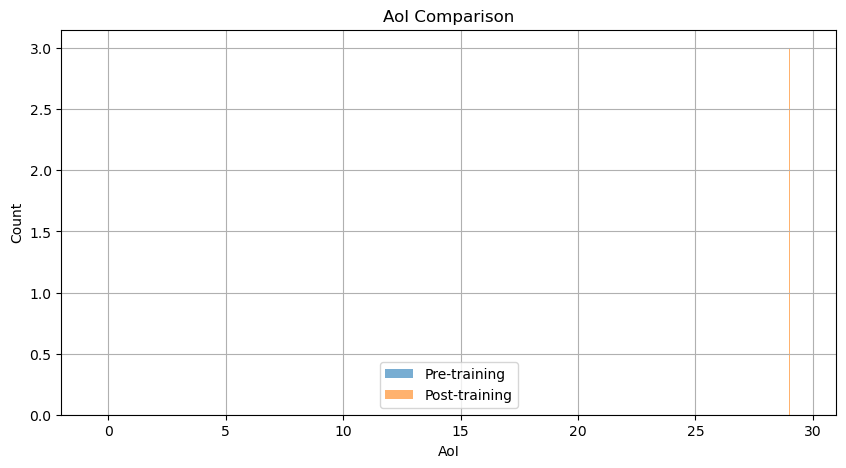

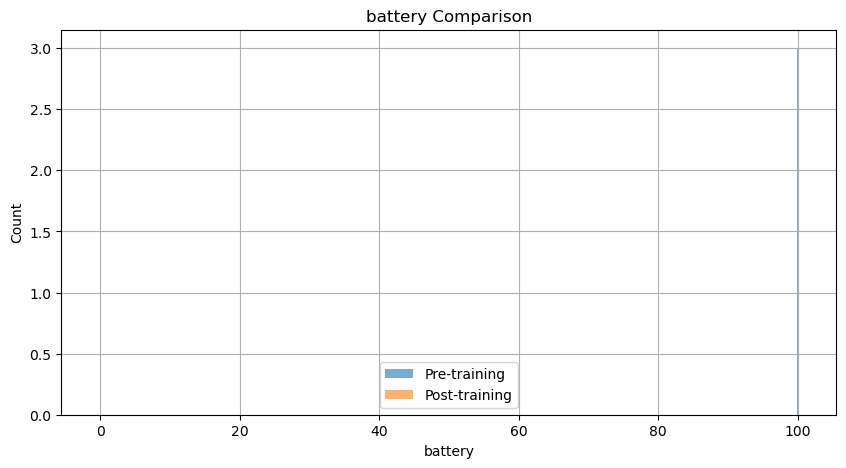

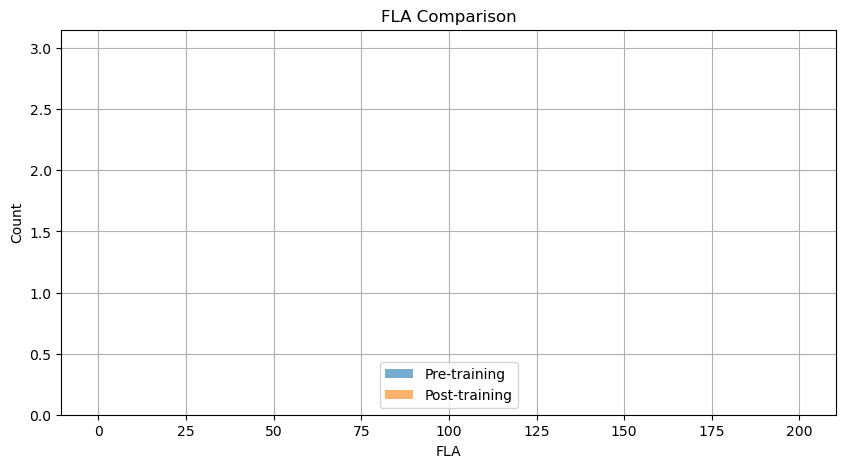

In [16]:
# ===============================
# ✅ UAV PPO Training Pipeline (Final)
# ===============================

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Import paths
sys.path.append('./env')
sys.path.append('./utils')

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from env.uav_env import RealTimeMultiUAVEnv
from utils.metrics import MetricsTracker

# =============================
# ✅ Patch .seed() method into the env class
# =============================
def add_seed_method():
    def seed(self, seed=None):
        np.random.seed(seed)
    setattr(RealTimeMultiUAVEnv, "seed", seed)

add_seed_method()

# =============================
# ✅ Patch step() to handle np.ndarray actions
# =============================
def patch_step_action_handler():
    original_step = RealTimeMultiUAVEnv.step
    def patched_step(self, actions):
        if isinstance(actions, np.ndarray):
            actions = np.squeeze(actions)
            if actions.ndim == 0:
                actions = [int(actions)]
            else:
                actions = actions.tolist()
        return original_step(self, actions)
    RealTimeMultiUAVEnv.step = patched_step

patch_step_action_handler()

# =============================
# ✅ Custom callback to track training metrics
# =============================
class TrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingCallback, self).__init__(verbose)
        self.episode_count = 0
        self.metrics = MetricsTracker()

    def _on_step(self) -> bool:
        if self.locals.get('dones', [False])[0]:
            self.episode_count += 1
            if self.episode_count % 10 == 0:
                env = self.training_env.envs[0].env
                coverage = np.sum(env.visited) / (env.grid_size ** 2)
                self.metrics.log_episode(
                    episode=self.episode_count,
                    coverage=coverage,
                    steps=env.step_count,
                    active_uavs=sum(1 for b in env.uav_batteries if b > 0),
                    total_spots=sum(env.uav_spotted)
                )
                if self.verbose:
                    print(f"Episode {self.episode_count}: Coverage={coverage:.2f}, Steps={env.step_count}")
        return True

# =============================
# ✅ Training Function
# =============================
def train_model(total_timesteps=50000, model_name="ppo_MultiUAVEnv"):
    print("🚁 Initializing UAV Training Environment...")
    vec_env = make_vec_env(lambda: RealTimeMultiUAVEnv(grid_size=10, num_uavs=3), n_envs=1)
    raw_env = vec_env.envs[0].env

    os.makedirs("data", exist_ok=True)
    pre_training_data = raw_env.generate_csv_data("data/pre_training_obs.csv")
    display(pre_training_data.head())

    print("🧠 Creating PPO model...")
    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=1,
        learning_rate=0.0003,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        tensorboard_log="logs/"
    )

    callback = TrainingCallback(verbose=1)

    print("🎯 Training started...")
    model.learn(total_timesteps=total_timesteps, callback=callback, tb_log_name="MultiUAV_PPO")

    os.makedirs("models", exist_ok=True)
    model_path = f"models/{model_name}"
    model.save(model_path)
    print(f"✅ Model saved to {model_path}.zip")

    print("🛫 Generating post-training data...")
    obs = vec_env.reset()
    done = False
    steps = 0

    while not done and steps < 200:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        steps += 1

    post_training_data = raw_env.generate_csv_data("data/post_training_obs.csv")
    display(post_training_data.head())

    callback.metrics.save_metrics("data/training_metrics.csv")

    print("📊 Training finished successfully!")
    return model, callback.metrics

# =============================
# ✅ Run Training
# =============================
model, metrics = train_model(total_timesteps=50000)
print("✅ All tasks completed!")

# =============================
# 📈 Compare Pre vs Post Metrics
# =============================
def compare_metric(metric):
    pre_df = pd.read_csv("data/pre_training_obs.csv")
    post_df = pd.read_csv("data/post_training_obs.csv")
    plt.figure(figsize=(10, 5))
    plt.hist(pre_df[metric], bins=15, alpha=0.6, label='Pre-training')
    plt.hist(post_df[metric], bins=15, alpha=0.6, label='Post-training')
    plt.title(f"{metric} Comparison")
    plt.xlabel(metric)
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_metric("AoI")
compare_metric("battery")
compare_metric("FLA")


In [30]:
import os

def create_html_visualization(env, model=None, max_steps=200):
    ...
    # (after generating html_content)

    # ✅ Save HTML file to visualize/real_time_visualization.html
    current_dir = os.path.dirname(os.path.abspath(__file__))
    output_path = os.path.join(current_dir, 'real_time_visualization.html')
    with open(output_path, 'w') as f:
        f.write(html_content)

    print(f"✅ HTML visualization saved to {output_path}")
    return html_content



In [3]:
import os
print("Files in current directory:")
print(os.listdir('.'))


Files in current directory:
['.git', '.ipynb_checkpoints', 'data', 'env', 'logs', 'main.ipynb', 'models', 'real_time_visualization.html', 'test.py', 'train.py', 'utils', 'visualize', '__pycache__']


In [4]:
import shutil

# Move the HTML to correct folder
shutil.move("real_time_visualization.html", "visualize/real_time_visualization.html")


'visualize/real_time_visualization.html'

In [5]:
with open("visualize/__init__.py", "w") as f:
    f.write("# Init file for visualize module")


In [21]:
with open('visualize/real_time_visualization.html', 'w') as f:
    f.write(html_content)


In [4]:
import webbrowser
webbrowser.open("visualize/real_time_visualization.html")


True

In [1]:
from visualize.visualize import create_html_visualization
from env.uav_env import RealTimeMultiUAVEnv
from stable_baselines3 import PPO

# Create environment
env = RealTimeMultiUAVEnv(grid_size=10, num_uavs=3)

# Load trained PPO model
model = PPO.load("models/ppo_MultiUAVEnv")

# Generate and save the HTML visualization
create_html_visualization(env, model)


✅ HTML visualization saved to visualize\real_time_visualization.html


'\n    <!DOCTYPE html>\n    <html>\n    <head>\n        <title>Real-Time Multi-UAV Visualization</title>\n        <script src="https://cdnjs.cloudflare.com/ajax/libs/d3/7.8.5/d3.min.js"></script>\n        <style>\n            body { font-family: Arial, sans-serif; margin: 20px; }\n            .container { display: flex; gap: 20px; }\n            .visualization { border: 1px solid #ccc; }\n            .controls { margin: 10px 0; }\n            .metrics { margin-top: 20px; }\n            .uav-info { margin: 5px 0; padding: 5px; border: 1px solid #ddd; }\n        </style>\n    </head>\n    <body>\n        <h1>Real-Time Multi-UAV Path Planning</h1>\n        \n        <div class="controls">\n            <button onclick="startAnimation()">Start</button>\n            <button onclick="pauseAnimation()">Pause</button>\n            <button onclick="resetAnimation()">Reset</button>\n            <span>Speed: </span>\n            <input type="range" id="speed" min="50" max="1000" value="200" onchan

In [2]:
from train.train import train_model
model, metrics = train_model(50000)



🚀 Initializing UAV training environment...
📦 Generating pre-training data...
     ID  source_time        lat       lon  source_spotted  track  \
0  UAV0            0  52.822992 -4.123736               0    154   
1  UAV1            0  52.819992 -4.125736               0    164   
2  UAV2            0  52.824992 -4.127736               0     81   

   takeoff_landing_time  battery  AoI  FLA  
0                     0      100  0.0    0  
1                     0      100  0.0    0  
2                     0      100  0.0    0  
🧠 Creating PPO model...
Using cpu device
🎯 Starting training for 50000 timesteps...
Logging to logs/MultiUAV_PPO_10


C:\Users\NAVYA SAI\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 520      |
| time/              |          |
|    fps             | 343      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | 507          |
| time/                   |              |
|    fps                  | 272          |
|    iterations           | 2            |
|    time_elapsed         | 15           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0068863966 |
|    clip_fraction        | 0.0603       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.82        |
|    explained_variance   | 0.00105      |
|    learning_r